# Imports

In [223]:

import os, sys, glob, gc
from dataclasses import dataclass, field

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

from read_matlab_data import DataFile
from organize_data import load_object

from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

from skimage.transform import rescale, resize

# Load Data

In [10]:
nrcan_frequencies = [ 5.382, 6.9285, 8.0995, 10.422, 11.107, 14.3644 ]

data_dic = {}

for freq in nrcan_frequencies:
    q, r = divmod(freq, 1)
    data_dic[freq] = load_object("data\\2019\\2019_%dp%.4d.dat" % (q, np.round(r,5)*1e4))

In [14]:
vars(data_dic[5.382][0])

{'file_path': 'D:\\OneDrive - University of Calgary\\All Projects\\nrcan_data\\matlab_files\\2019\\ddAle_Ott_20190721_05382000.mat',
 'data_dic': {'antindf': array([32,  0, 32, 32,  0, 32,  0, 32], dtype=uint8),
  'azimuth': array([207.47978013,  18.6979063 , 190.23365578, 193.88917873,
          11.98315901, 192.09159601,  61.41884064,  82.37375896,
           3.93253635, 204.93815151, 240.34609287,  49.46704772,
         192.73626287, 179.64968343, 195.49555391, 196.47798347,
         196.05389387, 191.87235051, 199.91909933,   9.55273456,
         195.71084166, 191.35881869, 305.92356319, 180.49254558,
         185.51144609, 174.10076247, 181.84797617, 262.75051173,
         201.97692173,  23.88418045,  76.23124   , 197.65909588]),
  'clock_oddity': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
  'delspread': array([1.32613631, 0.        , 0.4518269 , 0.15735829, 1.2       ,
         0.5       , 0.21784

In [ ]:
one_dic = data_dic[5.382]


In [124]:

colors = ("#F8EDD8", "#EEC069")

time_list = [data_file.date_time for data_file in one_dic]
fill_time_list = pd.date_range(time_list[0], time_list[-1]).to_pydatetime()

time_keeper = [time_list[0]]

for indx, time, in enumerate(time_list):
    
    time_ahead = time_list[indx + 1] if indx < len(time_list) -1 else time
    time_before = time_list[indx - 1] if indx > 0 else time
    
    if time_ahead - time >= timedelta(days=2) or time - time_before >= timedelta(days=2) :
        time_keeper.append(time)

else: time_keeper.append(time_list[-1])

time_diff_there = np.subtract( time_keeper[1::2], time_keeper[::2] )
time_diff_notthere = np.subtract( time_keeper[::2][1:], time_keeper[1::2][:-1] )


[datetime.datetime(2019, 7, 21, 0, 0), datetime.datetime(2019, 7, 22, 0, 0), datetime.datetime(2019, 7, 23, 0, 0), datetime.datetime(2019, 9, 17, 0, 0), datetime.datetime(2019, 9, 18, 0, 0), datetime.datetime(2019, 9, 19, 0, 0), datetime.datetime(2019, 9, 20, 0, 0), datetime.datetime(2019, 9, 21, 0, 0), datetime.datetime(2019, 9, 22, 0, 0), datetime.datetime(2019, 9, 23, 0, 0), datetime.datetime(2019, 10, 1, 0, 0), datetime.datetime(2019, 10, 2, 0, 0), datetime.datetime(2019, 10, 3, 0, 0), datetime.datetime(2019, 10, 4, 0, 0), datetime.datetime(2019, 10, 5, 0, 0), datetime.datetime(2019, 10, 6, 0, 0), datetime.datetime(2019, 10, 12, 0, 0), datetime.datetime(2019, 10, 13, 0, 0), datetime.datetime(2019, 10, 14, 0, 0), datetime.datetime(2019, 10, 15, 0, 0), datetime.datetime(2019, 10, 16, 0, 0), datetime.datetime(2019, 10, 17, 0, 0), datetime.datetime(2019, 10, 18, 0, 0), datetime.datetime(2019, 10, 19, 0, 0), datetime.datetime(2019, 10, 20, 0, 0)]
 
[datetime.datetime(2019, 7, 21, 0, 0),

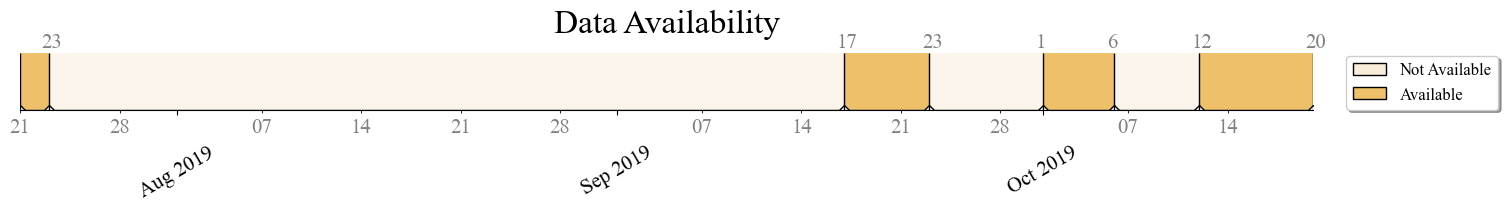

In [217]:


fig, ax = plt.subplots(figsize=(15, 2), constrained_layout=True)

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=np.arange(1, 13, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[0, 7, 14, 21, 28]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

ax.xaxis.set_tick_params(which="minor", labelsize="15", labelcolor="gray", rotation=0 )
ax.xaxis.set_tick_params(which="major", labelsize="15", labelcolor="k", rotation=30 , pad=20)

for time in time_keeper[1:]:
    ax.annotate( time.day, (time - timedelta(hours=12), 1.1), fontsize=15, color = "gray", annotation_clip=False)

ax.plot(time_keeper, np.zeros_like(time_keeper), marker="D", color="k", markerfacecolor="w", markersize=5)  

ax.broken_barh([ (start, diff) for start, diff in zip(time_keeper[::2], time_diff_there) ], (0, 1), facecolors=colors[-1])
ax.broken_barh([ (start, diff) for start, diff in zip(time_keeper[1::2], time_diff_notthere) ], (0, 1), facecolors=colors[0], alpha=0.5)

ax.vlines(time_keeper, 0, 1, color="k")

ax.set_xlim(time_list[0], time_list[-1])
ax.yaxis.set_visible(False)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0)

ax.set_title(  "Data Availability" , pad=15)

legend_elements = [ Patch(facecolor=color, edgecolor='k', label=label) for color, label in zip(colors, ["Not Available", "Available"]) ]
ax.legend(handles=legend_elements,  prop={'size': 12},  bbox_to_anchor=(1.15, 1.1), fancybox=True, shadow=True)

In [ ]:
nrcan_frequencies = [ 5.382, 6.9285, 8.0995, 10.422, 11.107, 14.3644 ]

data_dic = {}

for freq in nrcan_frequencies:
    q, r = divmod(freq, 1)
    data_dic[freq] = load_object("data\\2019\\2019_%dp%.4d.dat" % (q, np.round(r,5)*1e4))

In [501]:

@dataclass
class DataOrganizer:
    
    year: int
    
    frequencies: list[float] = field( default_factory= lambda: [ 5.382, 6.9285, 8.0995, 10.422, 11.107, 14.3644 ])
    colors: tuple = ("#F8EDD8", "#EEC069")
    
    
    def __post_init__(self):
        
        self.data_dic = {}
        
        for freq in self.frequencies:
            q, r = divmod(freq, 1)
            self.data_dic[freq] = load_object("data\\%4d\\%4d_%dp%.4d.dat" % ( self.year, self.year, q, np.round(r,5)*1e4))
            
            
        
    def sort_data_availability(self, freq):
        
        data_files = self.data_dic[freq]
        
        time_list = [data_file.date_time for data_file in data_files]
        fill_time_list = pd.date_range(time_list[0], time_list[-1]).to_pydatetime()

        time_keeper = [time_list[0]]
        odd_days = []
        for indx, time, in enumerate(time_list):
            
            time_ahead = time_list[indx + 1] if indx < len(time_list) -1 else time
            time_before = time_list[indx - 1] if indx > 0 else time
            
            ahead = time_ahead - time >= timedelta(days=2)
            before = time - time_before >= timedelta(days=2)
            
            if ahead and before:
                odd_days.append(time)
            
            elif ahead or before:
                time_keeper.append(time)

        else: time_keeper.append(time_list[-1])

        time_diff_there = np.subtract( time_keeper[1::2], time_keeper[::2] )
        time_diff_notthere = np.subtract( time_keeper[::2][1:], time_keeper[1::2][:-1] )
       
        return time_keeper, time_diff_there, time_diff_notthere, odd_days

    def plot_data_availability(self, freq, time_keeper, time_diff_there, time_diff_notthere, odd_days, ax, legend=False):
        

        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=np.arange(1, 13, 1)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

        ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[0, 7, 14, 21, 28]))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

        ax.xaxis.set_tick_params(which="minor", labelsize="15", labelcolor="gray", rotation=0 )
        ax.xaxis.set_tick_params(which="major", labelsize="15", labelcolor="k", rotation=30 , pad=20)

        for time in time_keeper[1:]:
            ax.annotate( time.day, (time - timedelta(hours=12), 1.05), fontsize=15, color = "gray",  xycoords='data', xytext=(1, 1), textcoords="offset points", annotation_clip=False, zorder=13, transform=ax.transData)

        for odd_time in odd_days:
            ax.annotate( odd_time.day, (odd_time - timedelta(hours=6), 1.05), fontsize=13, color = "gray", textcoords='data',  annotation_clip=False, zorder=13)


        ax.broken_barh([ (start, diff) for start, diff in zip(time_keeper[::2], time_diff_there) ], (0, 1), facecolors=self.colors[-1], zorder=9)
        ax.broken_barh([ (start, timedelta(days=1)) for start in odd_days ], (0, 1), facecolors=self.colors[-1], zorder=9)
        
        ax.broken_barh([ (start, diff) for start, diff in zip(time_keeper[1::2], time_diff_notthere) ], (0, 1), facecolors=self.colors[0], alpha=0.5, zorder=9)

        ax.plot(time_keeper, np.zeros_like(time_keeper), marker="D", color="k", markerfacecolor="w", markersize=5, zorder=13)  
        ax.vlines(time_keeper, 0, 1, color="k",zorder=12)

        ax.set_xlim(time_list[0], time_list[-1])

        ax.spines[["left", "top", "right"]].set_visible(False)

        ax.set_yticks([])
        ax.set_ylabel(  "%.4f MHz" % (freq), fontsize=15 )
        ax.margins(y=0)
        
        if legend:
            legend_elements = [ Patch(facecolor=color, edgecolor='k', label=label) for color, label in zip(self.colors, ["Not Available", "Available"]) ]
            ax.legend(handles=legend_elements,  prop={'size': 12},  bbox_to_anchor=(1, 2 ), fancybox=True, shadow=True)
        
    
    def show_data_availability(self):
        fig, axs = plt.subplots(len(self.frequencies), 1, figsize=(15, len(self.frequencies)*1.5), constrained_layout=True, sharex=True)
        
        for i, (freq, ax) in enumerate( zip(self.frequencies, axs) ):
            
            
            time_keeper, time_diff_there, time_diff_notthere, odd_days = self.sort_data_availability( freq )
            self.plot_data_availability(freq, time_keeper, time_diff_there, time_diff_notthere, odd_days, ax, legend=True if i==0 else False )

        fig.suptitle("Data Availability", va="top", x=0.5, y=1)
        
        return fig, axs
        

In [502]:
organizer = DataOrganizer(2019)

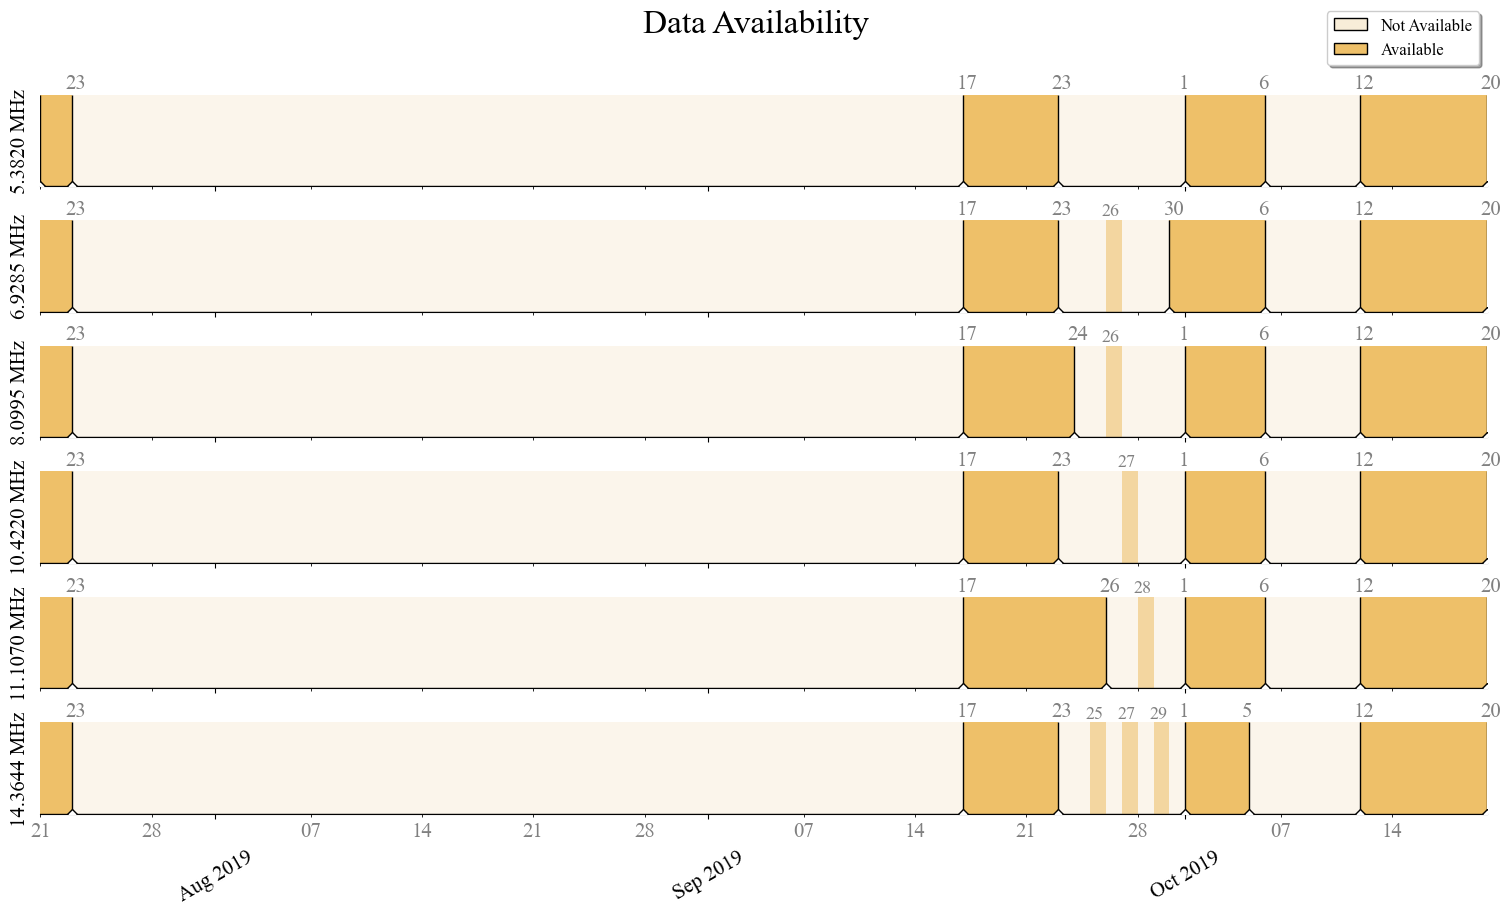

In [503]:
fig, axs = organizer.show_data_availability()